In [304]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import patsy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
%matplotlib inline
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [305]:
# Columns from kaggle dataset for reference
old_col= '''Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')'''

# Read in CSV

In [306]:
#df = pd.read_csv('~/Downloads/LoanStats3c.csv',header = 1)
#df.to_pickle('./data/loan_data_2014.zip',compression = 'zip')

# Drop unnecessary columns:

In [307]:
df = pd.read_pickle('./data/loan_data_2014.zip',compression = 'zip')
df.shape

(235631, 145)

In [308]:
df['delinq_amnt']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
         ... 
235601    0.0
235602    0.0
235603    0.0
235604    0.0
235605    0.0
235606    0.0
235607    0.0
235608    0.0
235609    0.0
235610    0.0
235611    0.0
235612    0.0
235613    0.0
235614    0.0
235615    0.0
235616    0.0
235617    0.0
235618    0.0
235619    0.0
235620    0.0
235621    0.0
235622    0.0
235623    0.0
235624    0.0
235625    0.0
235626    0.0
235627    0.0
235628    0.0
235629    NaN
235630    NaN
Name: delinq_amnt, Length: 235631, dtype: float64

In [309]:
# Only take rows of loans that are charged off or fully paid as results
df = df.loc[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [310]:
df=df.drop(columns = [
        # Only looking at loans for individuals, not joint
        'annual_inc_joint',
        'application_type',
        'dti_joint',
        'verification_status_joint',
        'revol_bal_joint', 

        # Don't need specific ID info
        'id',
        'member_id',
    
        # Only care about information available pre loan
        'collection_recovery_fee',
        'collections_12_mths_ex_med',
        'delinq_amnt',
        'last_credit_pull_d',
        'last_pymnt_amnt',
        'last_pymnt_d',
        'next_pymnt_d',
        'pymnt_plan',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_int',
        'total_rec_late_fee',
        'total_rec_prncp',
        # Hard to classify, may use regex text processing in future
        'emp_title',
    
        # hardship info is post issuing
        'hardship_flag',
        'hardship_status',
        'hardship_type',
        'hardship_reason',
        'deferral_term',
        'hardship_amount',
        'hardship_start_date',
        'hardship_end_date',
        'payment_plan_start_date',
        'hardship_length',
        'hardship_dpd',
        'hardship_loan_status',
        'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount',
        'hardship_last_payment_amount',
    

        # Trying to extrapolate beyond certain issuing dates of loans
        'issue_d',
        'mths_since_last_major_derog',
        'mths_since_last_record',
        'mths_since_recent_inq',
        'num_tl_30dpd',
        'num_tl_120dpd_2m',
        
        'debt_settlement_flag',
        'debt_settlement_flag_date',
        'desc',
    
        # sub_grade category already contains grade
        'grade',
    
        # This is for investors / loan funding
        'initial_list_status',
        'funded_amnt',
        'funded_amnt_inv',              
        # Probably useful metrics, but all NaN in this dataset              
        'open_acc_6m',                 
        'open_il_12m',
        'open_il_24m',                     
        'open_act_il',   
        'open_rv_12m',
        'open_rv_24m',
                      
        'out_prncp', 
        'out_prncp_inv',
        'policy_code',
        'recoveries',
        # Columns related to debt settlement; we only care about pre loan features              
        'settlement_status',
        'settlement_date',
        'settlement_amount',
        'settlement_percentage',
        'settlement_term',
        # Only looking for one applicant 
        #'sec_app_fico_range_low', 
        #'sec_app_fico_range_high', 
        'sec_app_earliest_cr_line', 
        'sec_app_inq_last_6mths', 
        'sec_app_mort_acc', 
        'sec_app_open_acc', 
        'sec_app_revol_util',
        'sec_app_open_act_il',
        'sec_app_num_rev_accts',
        'sec_app_chargeoff_within_12_mths',
        'sec_app_collections_12_mths_ex_med', 
        'sec_app_mths_since_last_major_derog', 
        'title',
        'total_cu_tl',
                      
        'url', 
        # May be good to look at later
        'zip_code'])

print('Before dropping NaN\'s: ',df.shape)
df.dropna(how='all', inplace = True)
print('After dropping NaN Rows: ',df.shape)
pre_drop_col = df.columns
df.dropna(axis=1, how='all',inplace = True)
print('After dropping NaN Columns: ',df.shape)
post_drop_col = df.columns

Before dropping NaN's:  (223102, 67)
After dropping NaN Rows:  (223102, 67)
After dropping NaN Columns:  (223102, 60)


In [311]:
dropped_nan_columns = set(pre_drop_col) - set(post_drop_col)
print("Dropped NaN Columns: ", dropped_nan_columns)

Dropped NaN Columns:  {'total_bal_il', 'max_bal_bc', 'inq_last_12m', 'mths_since_rcnt_il', 'il_util', 'inq_fi', 'all_util'}


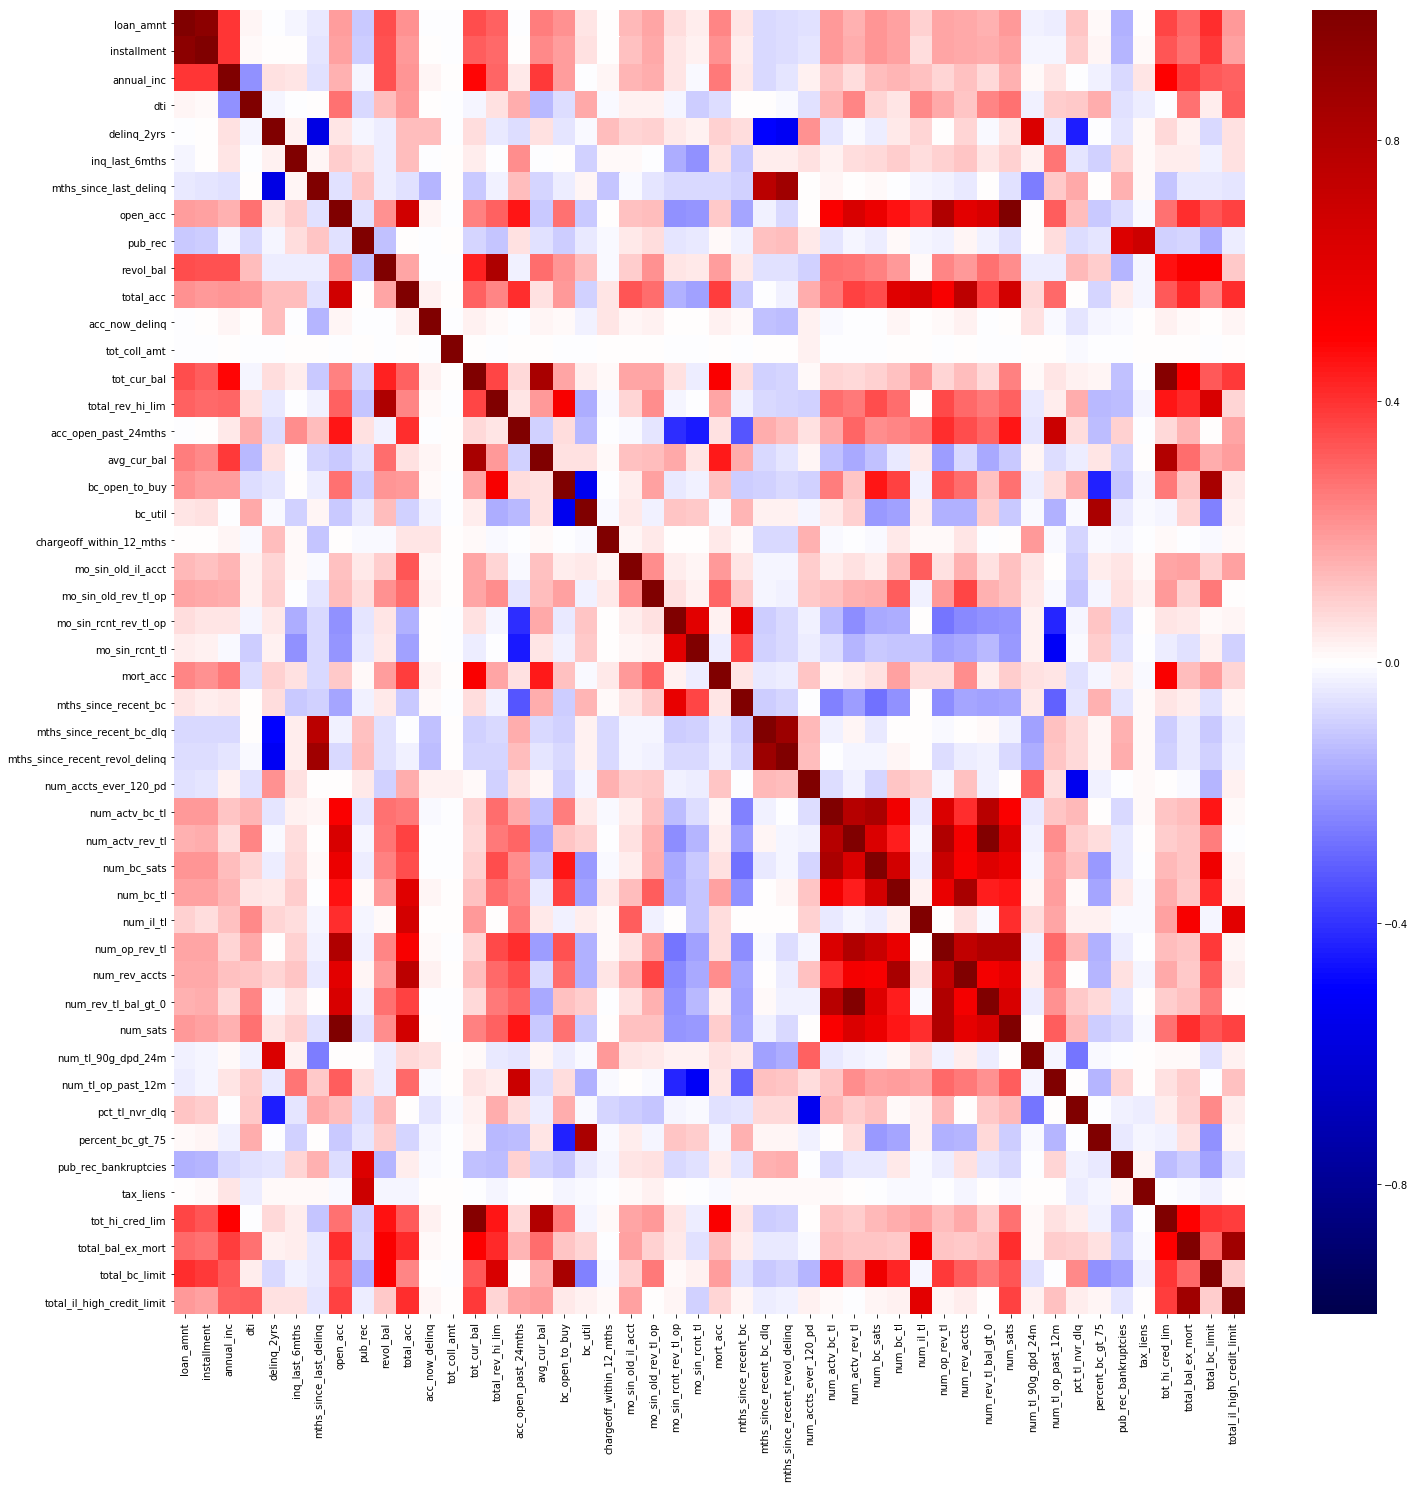

In [312]:

plt.figure(figsize=(24, 24))

sns.heatmap(df.corr(),vmin = -1, vmax = 1, cmap = 'seismic')

In [313]:
df.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
231389,10000.0,36 months,14.47%,344.07,C2,< 1 year,RENT,56000.0,Not Verified,Fully Paid,debt_consolidation,IL,21.58,0.0,Mar-1994,0.0,70.0,15.0,0.0,21766.0,87.8%,32.0,0.0,0.0,38377.0,24800.0,3.0,2952.0,710.0,94.9,0.0,144.0,238.0,7.0,7.0,0.0,20.0,NaN,NaN,1.0,4.0,11.0,5.0,8.0,6.0,13.0,24.0,11.0,15.0,0.0,2.0,96.9,75.0,0.0,0.0,48824.0,38377.0,13900.0,24024.0,Cash
183644,15000.0,60 months,14.64%,354.03,C3,10+ years,MORTGAGE,73000.0,Source Verified,Fully Paid,home_improvement,KS,23.16,0.0,Mar-1994,0.0,62.0,5.0,0.0,6172.0,85.7%,20.0,0.0,0.0,72782.0,7200.0,3.0,18196.0,1028.0,85.7,0.0,118.0,240.0,6.0,6.0,0.0,6.0,62.0,62.0,0.0,1.0,1.0,1.0,7.0,10.0,2.0,10.0,1.0,5.0,0.0,3.0,95.0,100.0,0.0,0.0,88536.0,72782.0,7200.0,81336.0,Cash
153423,5000.0,36 months,11.67%,165.29,B4,10+ years,RENT,54000.0,Not Verified,Fully Paid,debt_consolidation,WA,20.51,0.0,Apr-1997,0.0,45.0,5.0,0.0,1709.0,36%,15.0,0.0,0.0,30079.0,4750.0,2.0,6015.0,1750.0,98.0,0.0,179.0,205.0,30.0,4.0,0.0,30.0,45.0,45.0,0.0,1.0,2.0,1.0,2.0,8.0,2.0,5.0,1.0,5.0,0.0,1.0,67.0,100.0,0.0,0.0,39395.0,30079.0,1750.0,34645.0,Cash
109324,16200.0,36 months,11.67%,535.53,B4,< 1 year,RENT,36000.0,Source Verified,Fully Paid,debt_consolidation,UT,19.93,0.0,Nov-1984,0.0,32.0,10.0,0.0,26126.0,34.1%,36.0,0.0,0.0,26126.0,76600.0,3.0,2903.0,44474.0,37.0,0.0,135.0,356.0,15.0,15.0,4.0,15.0,NaN,32.0,2.0,5.0,5.0,8.0,18.0,2.0,10.0,30.0,5.0,10.0,0.0,0.0,94.4,50.0,0.0,0.0,76600.0,26126.0,70600.0,0.0,Cash
28518,35000.0,60 months,23.99%,1006.68,F2,9 years,MORTGAGE,115000.0,Verified,Charged Off,debt_consolidation,SC,13.85,0.0,Mar-1995,0.0,38.0,10.0,1.0,978.0,97.8%,24.0,0.0,0.0,314119.0,1000.0,1.0,34902.0,22.0,97.8,0.0,153.0,235.0,51.0,24.0,6.0,51.0,NaN,NaN,0.0,1.0,1.0,1.0,2.0,15.0,2.0,3.0,1.0,10.0,0.0,0.0,83.3,100.0,0.0,1.0,343121.0,108107.0,1000.0,117018.0,Cash


In [314]:
#df[df['num_tl_120dpd_2m'] >= 1][['num_tl_30dpd','num_tl_120dpd_2m','num_tl_90g_dpd_24m']]

In [315]:
# df[['int_rate','grade','sub_grade']].sort_values(by = 'int_rate')

# Clean Columns

In [316]:
def drop_percentage_signs(df, column_name):
    new_column_name = column_name + '_percent'
    df[new_column_name] = df[column_name].astype(str).str[:-1].astype(np.float64)
    return df.drop(columns = [column_name])

In [317]:
df.shape

(223102, 60)

In [318]:
#df['revol_util'].fillna('0%',inplace = True)
#df['revol_util'] =df['revol_util'].astype(str).str[:-1]


In [319]:
# Clean columns
# Convert loan terms into two categories 'short' and 'long'
df['term'] = df['term'].str.replace('36 months','short').str.replace('60 months','long').str.strip()

# Convert interest rate from percentage to float
df['int_rate'].dropna(axis = 0,how = 'any', inplace = True)
df=drop_percentage_signs(df,'int_rate')


# Fill Na's with 0.0% in revolving balance (unused revolving balance counts as NaN)
df['revol_util'].fillna(value = '0.0%',inplace = True)
df=drop_percentage_signs(df, 'revol_util')

In [320]:
df.shape

(223102, 60)

# One hot encoding 'Months Since' Variables

- First do a pd.cut() to bin the data into categories.
- Rename these during the function call
- Then fill nans as another category
- Run a pd.get_dummies on the resulting column

In [321]:
df['mths_since_last_delinq'] = \
pd.cut(df['mths_since_last_delinq'],5,labels =
       ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 

df['mths_since_recent_bc'] = \
pd.cut(df['mths_since_recent_bc'],5,labels =
       ['0-10 years','10-20 years','20-30 years','30-40 years','40-50 years']
      ).cat.add_categories('never').fillna('never')# 

df['mths_since_recent_bc_dlq'] = \
pd.cut(df['mths_since_recent_bc_dlq'],5, labels = 
      ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 

df['mths_since_recent_revol_delinq'] = \
pd.cut(df['mths_since_recent_revol_delinq'],5, labels = 
      ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 
df['mo_sin_old_il_acct'] = \
pd.cut(df['mo_sin_old_il_acct'],5).cat.add_categories('never').fillna('never')

In [322]:
def add_days_since_col(df,column_name):
    new_col_name = 'days_since_' + column_name
    df[new_col_name] = df[column_name].apply(lambda x: (dt.datetime.today().date() - 
                                                      dt.datetime.strptime(x,'%b-%Y').date()).days)
    return df.drop(columns = [column_name])
# df['days_since_earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: (dt.datetime.today().date() - 
#                                                       dt.datetime.strptime(x,'%b-%Y').date()).days)
#df=df.drop(columns = ['earliest_cr_line'])

df = add_days_since_col(df,'earliest_cr_line')
# Last credit pulled has data leakage because credit is constantly pulled for non-defaulted loans. 
#df= df.dropna(subset = ['last_credit_pull_d'])
#df = add_days_since_col(df,'last_credit_pull_d')

In [323]:
df.sample(5)

,loan_amnt,term,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,int_rate_percent,revol_util_percent,days_since_earliest_cr_line
156292,18000.0,short,547.84,A1,6 years,OWN,62000.0,Not Verified,Fully Paid,credit_card,FL,22.53,0.0,0.0,never,9.0,0.0,22178.0,22.0,0.0,85.0,132036.0,85000.0,4.0,16505.0,54988.0,26.7,0.0,"(100.2, 200.4]",239.0,3.0,3.0,3.0,0-10 years,never,never,0.0,3.0,5.0,3.0,4.0,9.0,6.0,10.0,5.0,9.0,0.0,1.0,100.0,33.3,0.0,0.0,210701.0,30634.0,75000.0,21701.0,Cash,6.03,26.1,9100
79309,7000.0,short,220.62,A5,2 years,RENT,41000.0,Verified,Fully Paid,debt_consolidation,IL,5.10,0.0,1.0,never,14.0,0.0,6066.0,22.0,0.0,0.0,6066.0,18700.0,3.0,433.0,7076.0,42.0,0.0,never,102.0,4.0,4.0,0.0,0-10 years,never,never,0.0,3.0,4.0,9.0,12.0,0.0,14.0,22.0,4.0,14.0,0.0,2.0,100.0,33.3,0.0,0.0,18700.0,6066.0,12200.0,0.0,Cash,8.39,32.4,4809
207523,10000.0,long,258.97,D4,10+ years,MORTGAGE,35000.0,Verified,Fully Paid,debt_consolidation,TX,19.72,0.0,0.0,never,6.0,0.0,8478.0,20.0,0.0,542.0,46939.0,12200.0,2.0,9387.0,7200.0,91.0,0.0,"(100.2, 200.4]",397.0,75.0,2.0,0.0,0-10 years,never,never,0.0,1.0,2.0,1.0,2.0,15.0,2.0,5.0,2.0,5.0,0.0,2.0,90.0,100.0,0.0,0.0,61569.0,46939.0,7200.0,49369.0,Cash,18.92,69.0,13999
133635,12000.0,short,371.19,A3,8 years,OWN,40000.0,Source Verified,Fully Paid,credit_card,AZ,19.23,0.0,3.0,never,10.0,0.0,12342.0,24.0,0.0,0.0,45350.0,33700.0,3.0,4535.0,6858.0,64.3,0.0,"(-0.501, 100.2]",95.0,17.0,5.0,0.0,0-10 years,never,never,0.0,5.0,5.0,5.0,6.0,16.0,6.0,8.0,5.0,10.0,0.0,2.0,100.0,20.0,0.0,0.0,74159.0,45350.0,19200.0,40459.0,Cash,7.12,36.6,4687
24445,12075.0,short,397.85,B4,3 years,MORTGAGE,78000.0,Source Verified,Fully Paid,credit_card,MD,10.82,0.0,1.0,never,11.0,0.0,8690.0,17.0,0.0,0.0,337282.0,16100.0,5.0,30662.0,4246.0,62.8,0.0,"(100.2, 200.4]",58.0,4.0,4.0,1.0,0-10 years,never,never,0.0,3.0,6.0,3.0,4.0,8.0,6.0,8.0,6.0,11.0,0.0,4.0,100.0,33.3,0.0,0.0,365073.0,14689.0,11400.0,25973.0,Cash,11.44,54.0,6482


# Patsy.dmatrix (pass string like last project, but no y~)

In [324]:
df.loc[df['mo_sin_old_il_acct'].isna()].head()

,loan_amnt,term,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,int_rate_percent,revol_util_percent,days_since_earliest_cr_line


In [325]:
#df.loc[df['percent_bc_gt_75'].isna()]

In [326]:
df.shape

(223102, 60)

In [327]:
sum(df_temp['loan_status'] == 1)/df_temp.shape[0]

0.29880855672894663

In [328]:
# What NA Columns are we dropping
df.isnull().sum()[df.isnull().sum() != 0]

emp_length          11554
avg_cur_bal             6
bc_open_to_buy       2328
bc_util              2482
percent_bc_gt_75     2437
dtype: int64

In [329]:
df_temp = df.dropna()
# Only look at low grades
df_temp = df_temp.loc[df_temp['sub_grade'].apply(lambda element: ('D' in element) | ('E' in element))]

In [330]:
# Convert target to binary,
df_temp['loan_status'] = df_temp['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})

In [331]:
# Define a 'basic' dataframe that only predicts off LendingClub sub_grade feature
df_basic= df_temp[['loan_status','sub_grade']]
df_basic.shape

(53510, 2)

In [332]:
def patsy_string_from_df(df):
    """Makes patsy string from dataframe df. Drops 'loan_status' variable by default."""
    df = df.drop(columns = ['loan_status']) # Drop the target variable, in this case it's loan_status
    patsy_string = ''
    for title in df.columns:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    # print("Patsy String: " +patsy_string)
    return patsy_string

In [333]:
# Make patsy design matrix from all dataframe 
# This takes care of onehot variables
X = patsy.dmatrix(patsy_string_from_df(df_temp),df_temp)
y = df_temp['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)

In [334]:
Xb = patsy.dmatrix(patsy_string_from_df(df_basic),df_basic)
yb = df_basic['loan_status'].values
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=123456)

In [335]:
# Fit random forest 
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [336]:
# Fit random forest to basic model (sub_grade only)
clf_b = RandomForestClassifier()
clf_b.fit(Xb_train,yb_train)
predicted_b = clf_b.predict(Xb_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<Figure size 480x320 with 0 Axes>

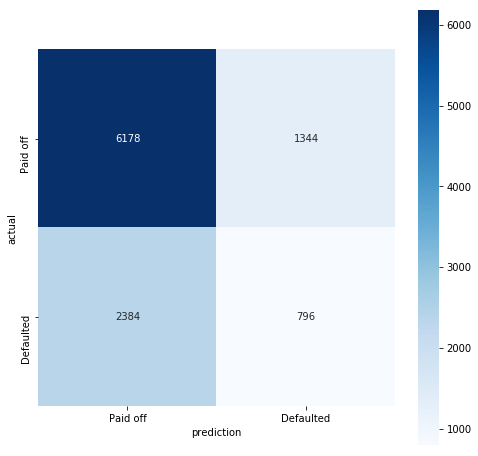

In [349]:
def make_confusion_matrix(model, threshold=.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    mat_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    plt.figure(figsize=(8, 8))
    sns.heatmap(mat_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Paid off', 'Defaulted'],
           yticklabels=['Paid off', 'Defaulted']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

cm = pd.DataFrame(confusion_matrix(y_test, predicted))
make_confusion_matrix(clf)



f1_score:  0.18239146252728594
ROC AUC score =  0.5659880702141643
ROC AUC score baseline =  0.5591714827282319


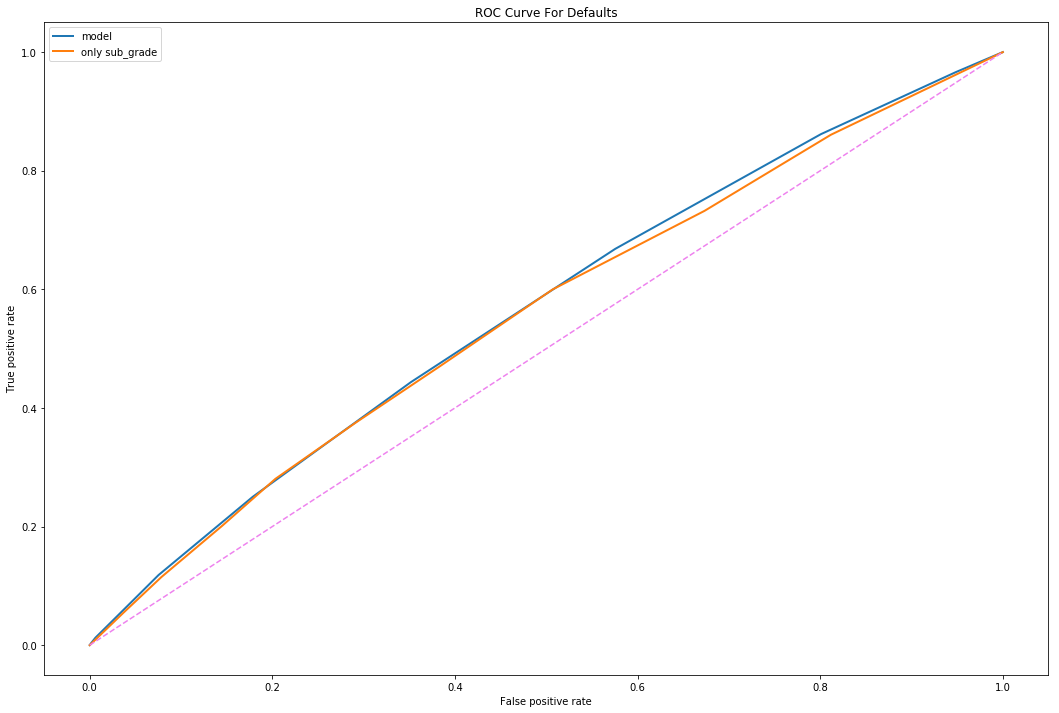

In [345]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
fpr_b, tpr_b, thresholds_b = roc_curve(yb_test, clf_b.predict_proba(Xb_test)[:,1])
print('f1_score: ', f1_score(y_test,predicted))
plt.figure(figsize=(18, 12))
plt.plot(fpr, tpr,lw=2, label = 'model')
plt.plot(fpr_b,tpr_b,lw=2, label = 'only sub_grade')

# This is the 100% random guess line
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc='upper left')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve For Defaults');
print("ROC AUC score = ", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
print("ROC AUC score baseline = ", roc_auc_score(yb_test, clf_b.predict_proba(Xb_test)[:,1]))



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic score: 0.7021


<Figure size 864x864 with 0 Axes>

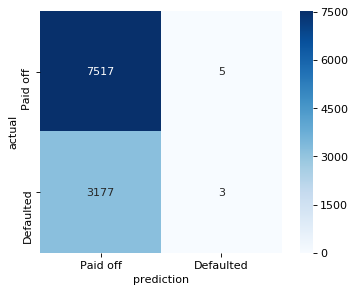

In [346]:
# Let's make a slightly better model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)
lm = LogisticRegression(C = 100)
lm.fit(X_train, y_train)
print("Logistic score: {:6.4f}".format(lm.score(X_train,y_train)))



make_confusion_matrix(lm)

ROC AUC score =  0.6018324863419504


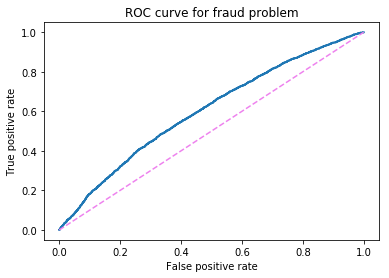

In [341]:

fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, lm.predict_proba(X_test)[:,1]))

In [142]:
Xb_test

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

# Write a COST FUNCTION
(Loans classified as defaulted but fully paid off * average paid off loan amount ) - 
(loans classified as paid off but defaulted * average loss to defaulted loan amount)